# XGBoost model

In [315]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

import modify_dataset as md

In [316]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [317]:
df = pd.read_csv("dataset/preprocessed_PCA_train.csv")

In [318]:
df = df.drop(['NumberOfCustomers'], axis=1)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [319]:
df = df[df.IsOpen == 1]

In [320]:
#for now let's drop unusable categorical vars
df = df.drop(['StoreType','AssortmentType','Events'], axis=1)

In [321]:
#only for PCA
df = df.drop(['Unnamed: 0'], axis=1)

In [322]:
df.head(20).T

,0,1,2,3,5,6,7,8,9,10,12,13,14,15,16,17,19,20,21,22
StoreID,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Date,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-28,2016-03-29,2016-03-30,2016-03-31
IsHoliday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
IsOpen,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
HasPromotions,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,1,1,1
NearestCompetitor,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326
Region,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
NumberOfSales,8804,7823,7989,5895,6348,4738,6014,6087,6962,6618,9183,8155,7109,8041,7890,6005,8550,8589,9055,11907
Region_AreaKM2,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643
Region_GDP,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130


In [323]:
df.shape

(433952, 48)

In [324]:
train = md.get_fake_train(df)

In [325]:
train.shape

(397041, 48)

In [326]:
test = md.get_fake_test(df)
test.shape

(36911, 48)

In [327]:
#print("Load the training, test and store data using pandas")
#train = pd.read_csv("train.csv",low_memory=False)
#test = pd.read_csv("test.csv")
#store = pd.read_csv("store.csv")

### Selecting predictive features 

In [328]:
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('Date')
features.remove('IsOpen')
features.remove('IsOpen_t-7')
features.remove('IsOpen_t-4')  #Is Open lags worsen a lot
features.remove('IsOpen_t-1')
features.remove('HasPromotions_t-2')
features.remove('HasPromotions_t-1')
#features.remove('Region_GDP')
#features.remove('Max_Dew_PointC')
#features.remove('Min_Dew_PointC')
#features.remove('Max_Wind_SpeedKm_h')
#features.remove('Max_VisibilityKm')
#features.remove('IsOpen')
#features.remove('Min_Sea_Level_PressurehPa')
#features.remove('Precipitationmm')
#features.remove('Mean_Dew_PointC')
#features.remove('Min_TemperatureC')
print("features")

print(features)

features
['IsHoliday', 'HasPromotions', 'NearestCompetitor', 'Region', 'Region_AreaKM2', 'Region_GDP', 'Region_PopulationK', 'CloudCover', 'Max_VisibilityKm', 'Min_VisibilitykM', 'WindDirDegrees', 'D_Day', 'D_DayOfYear', 'D_Month', 'D_Year', 'D_DayOfweek', 'StoreType_SuperMarket', 'StoreType_HyperMarket', 'StoreType_StandardMarket', 'StoreType_ShoppingCenter', 'AssortmentType_General', 'AssortmentType_WithNFDept', 'AssortmentType_WithFishDept', 'Events_Fog', 'Events_Hail', 'Events_Rain', 'Events_Snow', 'Events_Thunderstorm', 'MeanStoreSales', 'MeanRegionSales', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']


In [329]:
features.remove('p6')
features.remove('p3')
features.remove('p7')
features.remove('p9')
features.remove('Events_Thunderstorm')
features.remove('Events_Fog')

In [330]:
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3, #0.3
          "silent": 1,
          "nthread":-1,
          #added as a test
          #"eval_metric": "rmse",
          #"gamma": 2  #added as a test
          }

#reg_alpha 
#reg_lambda
num_trees = 400 #400

In [331]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [332]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [333]:
X_train.shape

(396643, 48)

In [334]:
X_test.shape

(398, 48)

In [335]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

[0]	test-rmse:6.34986	train-rmse:6.33681	test-rmspe:0.998321	train-rmspe:0.998245
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 20 rounds.
[1]	test-rmse:5.08127	train-rmse:5.07211	test-rmspe:0.993548	train-rmspe:0.993395
[2]	test-rmse:4.06948	train-rmse:4.06321	test-rmspe:0.981877	train-rmspe:0.981564
[3]	test-rmse:3.2615	train-rmse:3.25738	test-rmspe:0.959109	train-rmspe:0.958507
[4]	test-rmse:2.6168	train-rmse:2.61404	test-rmspe:0.921966	train-rmspe:0.920978
[5]	test-rmse:2.10007	train-rmse:2.09906	test-rmspe:0.86982	train-rmspe:0.868594
[6]	test-rmse:1.6901	train-rmse:1.68952	test-rmspe:0.804462	train-rmspe:0.802777
[7]	test-rmse:1.36259	train-rmse:1.3636	test-rmspe:0.729712	train-rmspe:0.727999
[8]	test-rmse:1.10399	train-rmse:1.10606	test-rmspe:0.651088	train-rmspe:0.649445
[9]	test-rmse:0.895376	train-rmse:0.899715	test-rmspe:0.572975	train-rmspe:0.572597
[10]	test-rmse:0.73253	train-rmse:0.

In [336]:
#watchlist = [(dvalid, 'test'), (dtrain, 'train')]
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

### Validating

In [337]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.10421074768039154


RMSE

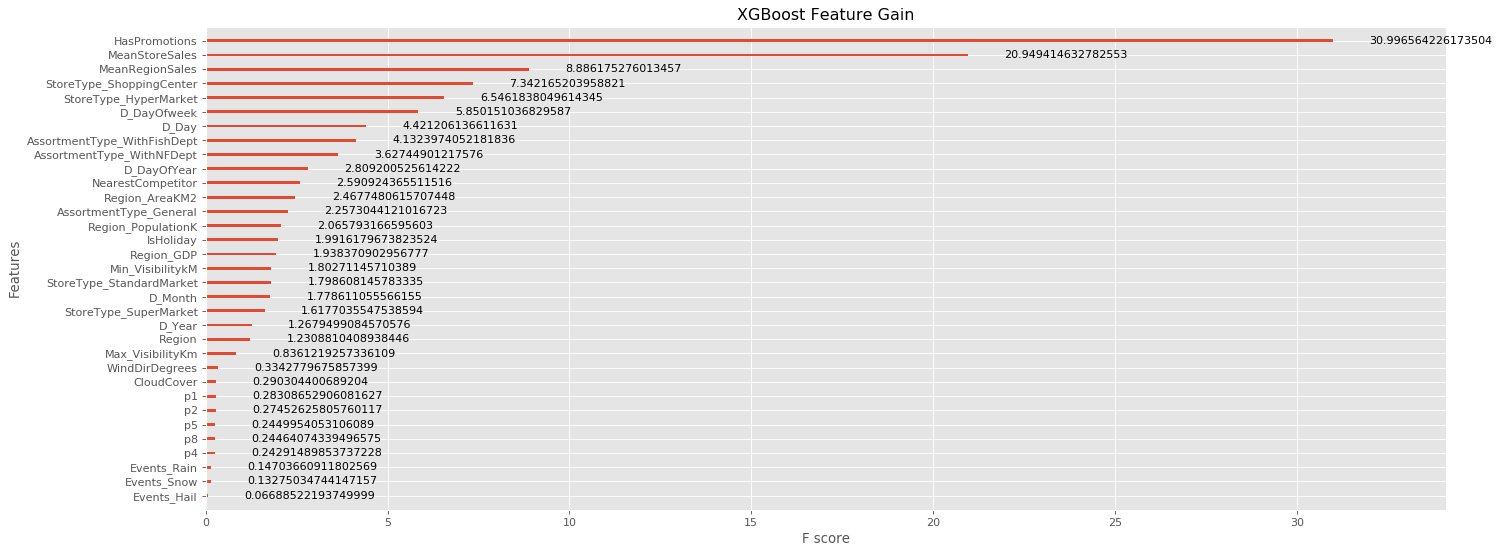

In [338]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

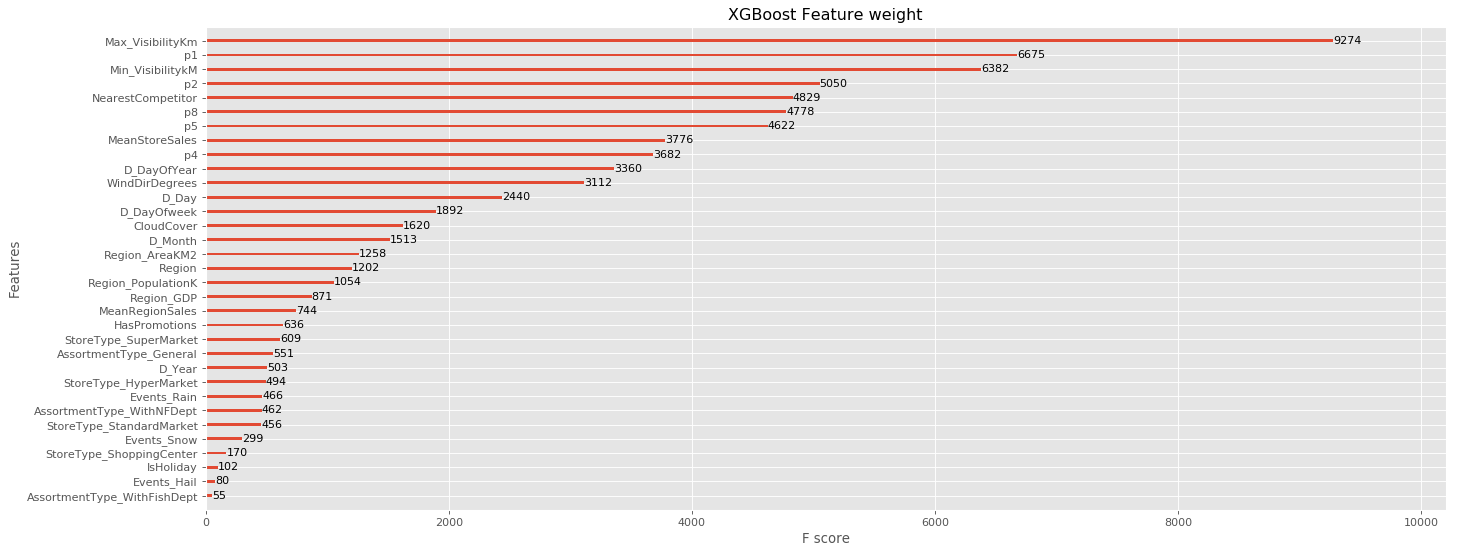

In [339]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

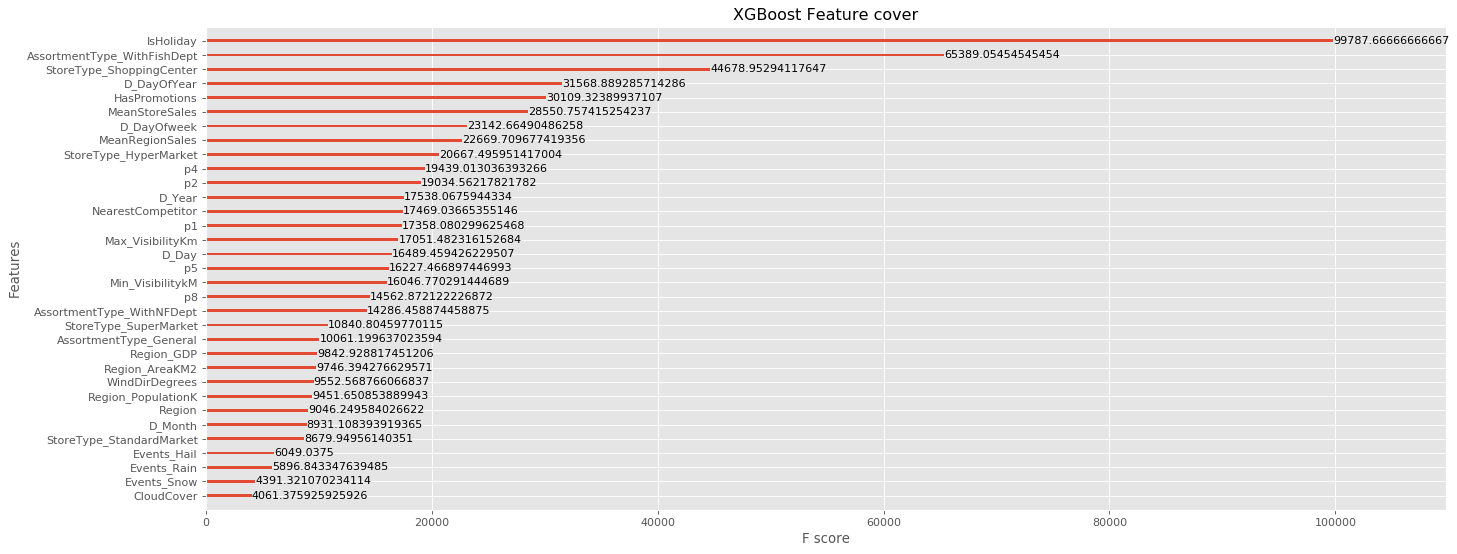

In [340]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [341]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [342]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [343]:
from BIP_error import get_BIP_error
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.04560578889758699


In [192]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [193]:
diff.head(15).T

343   -1020.562500
344   -1001.001465
345     766.709473
346    1024.638672
347    -330.423629
348     563.083984
349     496.740234
350    -157.377930
351       9.276855
352    -438.596680
353    -846.928223
354    -334.380172
355   -1159.650391
356    -784.121582
357    -883.473633
dtype: float64

In [194]:
diff.mean()

105.68320384653046

In [195]:
train_probs.shape

(45689,)

In [196]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [197]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [198]:
#test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [199]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

error 0.1906332633043559


In [200]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
11847,3674.000000,2806.333984
11848,3758.073991,3694.969727
11849,3468.000000,3293.965820
11850,2836.000000,2913.733887
11851,2816.000000,3009.757080
11852,2919.000000,3098.549072
11853,4054.000000,3707.348145
11854,3793.000000,2729.045654
11855,3758.073991,3996.481689
11856,6245.000000,5123.181641


In [161]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
11847,3674.000000,2922.143555
11848,3758.073991,3691.728271
11849,3468.000000,3240.204102
11850,2836.000000,2986.788574
11851,2816.000000,3042.273438
11852,2919.000000,3069.326172
11853,4054.000000,3740.238281
11854,3793.000000,2866.475586
11855,3758.073991,3973.737549
11856,6245.000000,4872.062988


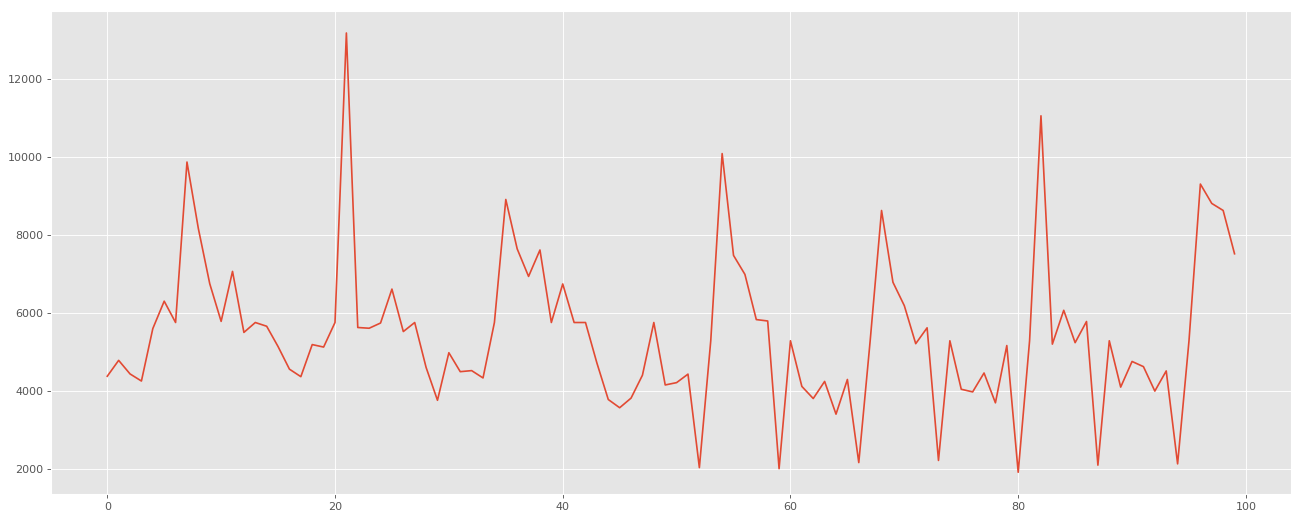

In [201]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

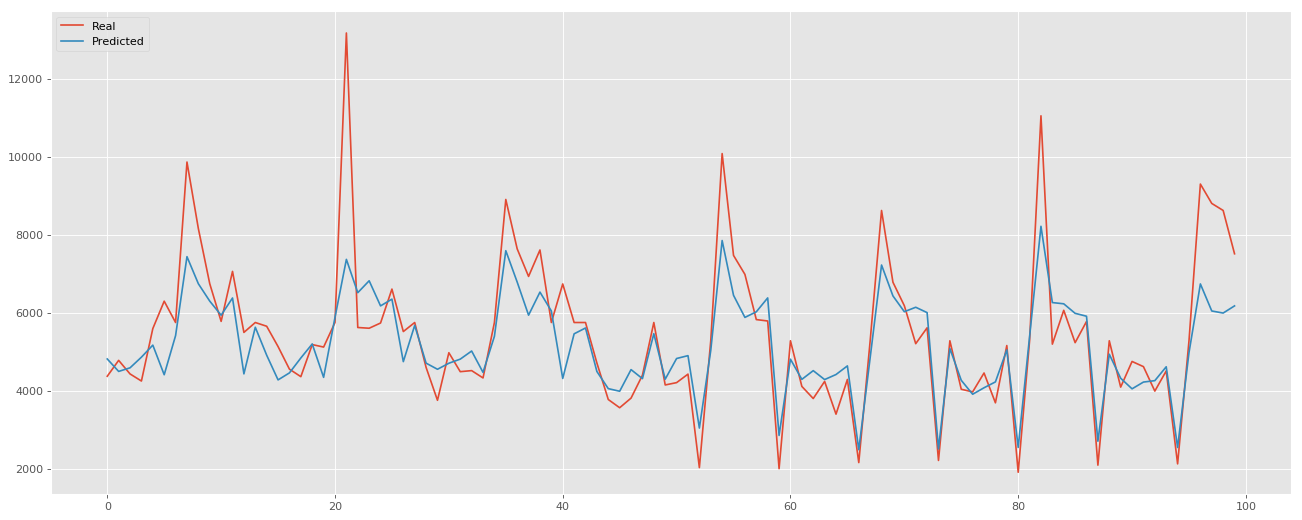

In [202]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [ ]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]

In [ ]:
Y